In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import minimize
from scipy.integrate import quad
sns.set_theme()

# Problem 1

Use the data in problem1.csv. Fit a Normal Distribution and a Generalized T distribution to this data.
Calculate the VaR and ES for both fitted distributions.

Overlay the graphs the distribution PDFs, VaR, and ES values. What do you notice? Explain the
differences.

## 1.1 Fitted Distribution Prototype

In [3]:
class FittedModel:
    '''The prototype of fitted distribution.'''
    def __init__(self):
        self.dist=self.set_dist() # the distribution
        self.frz_dist=None # the distribution which has specific parameters

    def set_dist(self):
        '''Need to be implemented in subclass to set the dist.'''
        raise NotImplementedError
    
    def freeze_dist(self,parameters):
        '''Need to be implemented in subclass to set the parameters of different distribution.'''
        raise NotImplementedError

    def fit(self,data,x0,cons):
        '''
        Use MLE to fit the distribution
        x0 is initial paremeters which needed to be implemented in subclass
        cons is constraints of parameters which needed to be implemented in subclass
        '''
        def nll(parameters,x):
            '''Negative likelihood function'''
            self.freeze_dist(parameters)
            ll=self.frz_dist.logpdf(x=x).sum()
            return -ll
        MLE = minimize(nll, x0=x0, args=data, constraints = cons) # MLE 
        self.freeze_dist(MLE.x)
        self.fitted_parameters=MLE.x

    @property
    def fitted_dist(self):
        return self.frz_dist


## 1.2 Fitted Normal Distribution

In [4]:
class Norm(FittedModel):
    def set_dist(self):
        '''set the distribution to be normal'''
        return stats.norm
        
    def freeze_dist(self,parameters):
        '''set the parameters of norm: parameters[0]--mu, parameters[1]--std'''
        self.frz_dist=self.dist(loc=parameters[0],scale=parameters[1])

    def fit(self,data):
        '''set the initial parameters and cons to call the father's fit'''
        x0 = (data.mean(),data.std())  # initial paremeters
        cons = [ {'type':'ineq', 'fun':lambda x:x[1]} ] # standard deviation is non-negative
        super().fit(data,x0,cons)

## 1.3 Fitted Fit Generalized T Distribution

In [5]:
class T(FittedModel):
    def set_dist(self):
        '''set the distribution to be normal'''
        return stats.t
        
    def freeze_dist(self,parameters):
        '''set the parameters of norm: parameters[0]--degree of freedom, parameters[1]--mu, parameters[2]--std'''
        self.frz_dist=self.dist(df=parameters[0],loc=parameters[1],scale=parameters[2])
        
    def fit(self,data):
        '''set the initial parameters and cons to call the father's fit'''
        # degree of freedom of t should be greater than 2; standard deviation is non-negative
        cons=[ {'type':'ineq', 'fun':lambda x:x[0]-2} , {'type':'ineq', 'fun':lambda x:x[2]} ] 
        x0 = np.array([2,0,1]) # initial parameter
        super().fit(data,x0,cons)

## 1.4 Risk Metrics

In [6]:
class RiskMetrics:
    @staticmethod
    def VaR_dist(dist,alpha=0.05):
        '''Given a distribution and alpha, calculate the corresponding VaR'''
        return -dist.ppf(alpha)

    @staticmethod
    def ES_dist(dist,alpha=0.05):
        '''Given a distribution and alpha, calculate the corresponding Expected Shortfall'''
        lb=-np.inf   
        ub=dist.ppf(alpha)
        return -dist.expect(lb=lb,ub=ub)/alpha # integral
    
    @staticmethod
    def VaR_historical(data,alpha=0.05):
        '''Given a dataset(array), calculate the its historical VaR'''
        data.sort()
        n=round(data.size*alpha)
        return -data[n-1]
    
    @staticmethod
    def ES_historical(data,alpha=0.05):
        '''Given a dataset(array), calculate the its historical Expected Shortfall'''
        data.sort()
        n=round(data.size*alpha)
        return -data[:n].mean()
    

## 1.5 Fit the distribution & Plot

In [7]:
data=pd.read_csv('problem1.csv') # read the data
data=np.array(data.values).reshape(data.size) # transform to array

# Fit the normal distribution
norm=Norm()
norm.fit(data)
fitted_norm=norm.fitted_dist

# Fit the T distribution
t=T()
t.fit(data)
fitted_t=t.fitted_dist

# Calculate the VaR & ES
VaR_normal=RiskMetrics.VaR_dist(fitted_norm)
ES_normal=RiskMetrics.ES_dist(fitted_norm)
VaR_t=RiskMetrics.VaR_dist(fitted_t)
ES_t=RiskMetrics.ES_dist(fitted_t)

# Print the VaR & ES comparision of Normal and T
print('Normal VaR ({}) vs. Normal ES ({})'.format(VaR_normal,ES_normal))
print('T VaR ({}) vs. T ES ({})'.format(VaR_t,ES_t))
print('-'*60)
print('Normal VaR ({}) vs. T VaR ({})'.format(VaR_normal,VaR_t))
print('Normal ES ({}) vs. T ES ({})'.format(ES_normal,ES_t))

Normal VaR (0.08125483146358596) vs. Normal ES (0.10167332455409121)
T VaR (0.07647782750577499) vs. T ES (0.11321929961341247)
------------------------------------------------------------
Normal VaR (0.08125483146358596) vs. T VaR (0.07647782750577499)
Normal ES (0.10167332455409121) vs. T ES (0.11321929961341247)


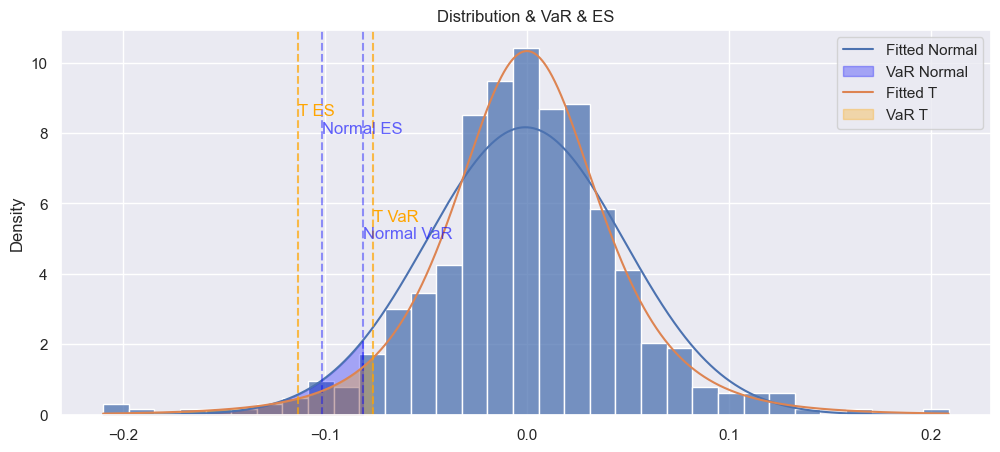

In [7]:
# plot
num=10000
lb=data.min()
ub=data.max()
x=np.linspace(lb,ub,num)
y_norm=fitted_norm.pdf(x)
y_t=fitted_t.pdf(x)
plt.figure(figsize=(12,5))
sns.histplot(data,stat="density") # plot the density of dataset

plt.plot(x,y_norm,label='Fitted Normal') # plot the fitted normal
plt.fill_between(x,y_norm,where=x<-VaR_normal,color="blue", alpha=0.3,label='VaR Normal') # fill VaR area
plt.axvline(-VaR_normal,color="blue",alpha=0.4,linestyle='--') # plot the vertical line of VaR_normal
plt.axvline(-ES_normal,color="blue",alpha=0.4,linestyle='--') # plot the vertical line of ES_normal
plt.text(-VaR_normal,5,s='Normal VaR',color="blue",alpha=0.6)
plt.text(-ES_normal,8,s='Normal ES',color="blue",alpha=0.6)


plt.plot(x,y_t,label='Fitted T') # plot the fitted t
plt.fill_between(x,y_t,where=x<-VaR_t,color="orange", alpha=0.3,label='VaR T') # fill VaR area
plt.axvline(-VaR_t,color="orange" ,alpha=0.7,linestyle='--') # plot the vertical line of VaR_t
plt.axvline(-ES_t,color="orange" ,alpha=0.7,linestyle='--') # plot the vertical line of ES_t
plt.text(-VaR_t,5.5,s='T VaR',color="orange",alpha=1)
plt.text(-ES_t,8.5,s='T ES',color="orange",alpha=1)


plt.title("Distribution & VaR & ES")
plt.legend()

# Problem 3:

Use your repository from #2.

Using Portfolio.csv and DailyPrices.csv. Assume the expected return on all stocks is 0.

This file contains the stock holdings of 3 portfolios. You own each of these portfolios.

Fit a Generalized T model to each stock and calculate the VaR and ES of each portfolio as well as your total VaR and ES. Compare the results from this to your VaR form Problem 3 from Week 4.

## Generalized T model & Gaussian Copula

In [2]:
from RiskPackage.CalculateReturn import return_calculate
from RiskPackage.SimulationMethods import Simulator
from RiskPackage.RiskMetrics import VaR_portfolio,RiskMetrics
np.seterr(divide='ignore', invalid='ignore')
from RiskPackage.ModelFitter import T_mean0

In [3]:
# parse the DailyPrices data into dataframe
price=pd.read_csv('DailyPrices.csv',index_col='Date')
# calculate the returns & remove the mean
rt=return_calculate(price,rm_means=True)
# information about portfolio
portfolio=pd.read_csv('portfolio.csv',index_col='Portfolio')

VaR of portfolio A is 8081.647729089386
ES of portfolio A is 10848.15680652159
VaR of portfolio B is 6743.747792556508
ES of portfolio B is 8769.368492594556
VaR of portfolio C is 5755.147350846125
ES of portfolio C is 7558.39316077591
VaR of portfolio All is 20537.05690711626
ES of portfolio All is 27094.674980924763


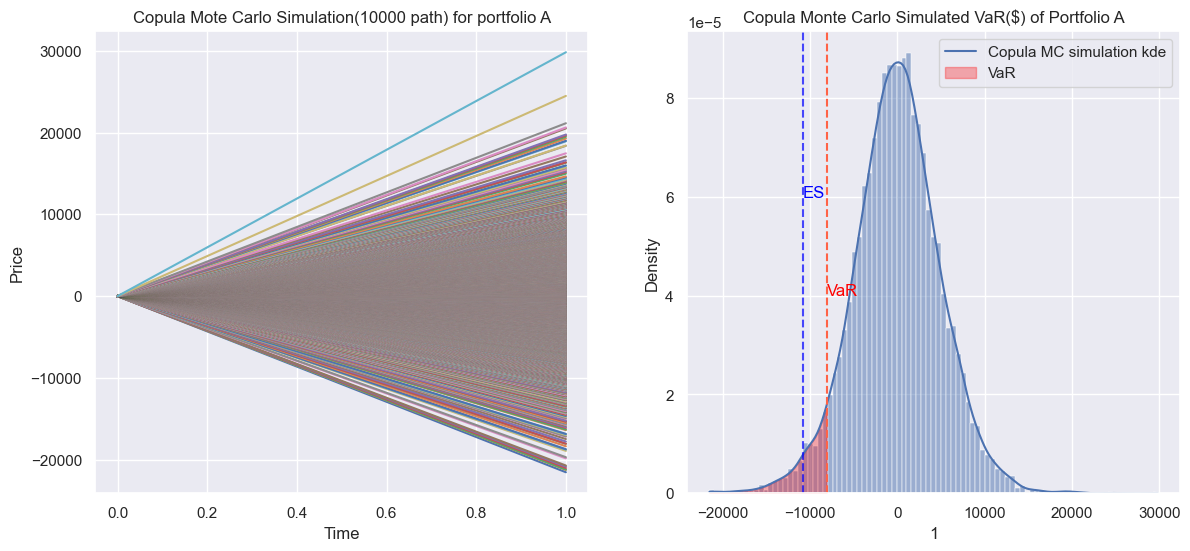

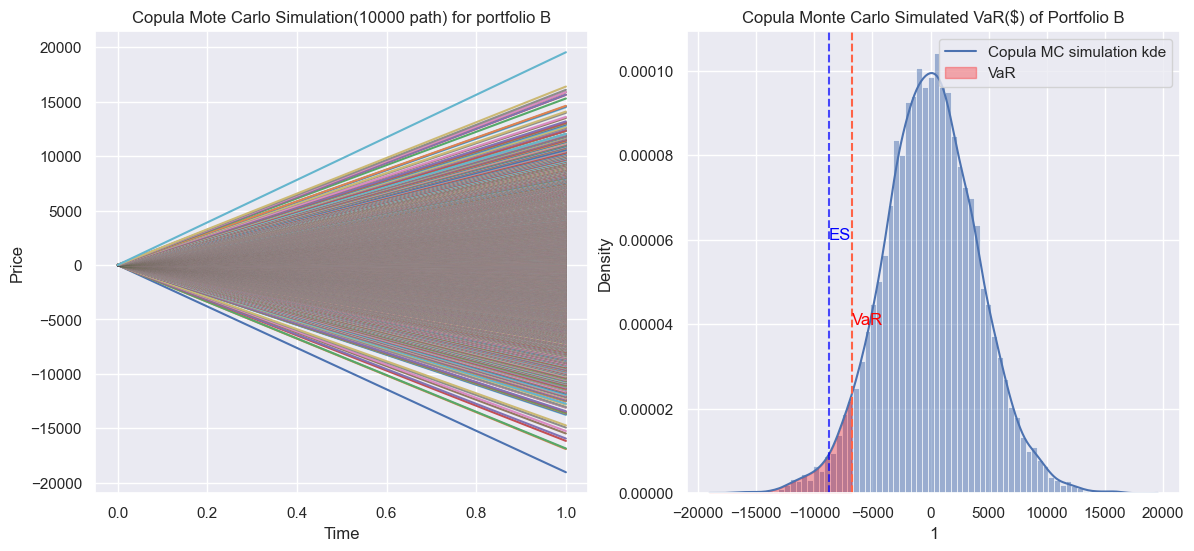

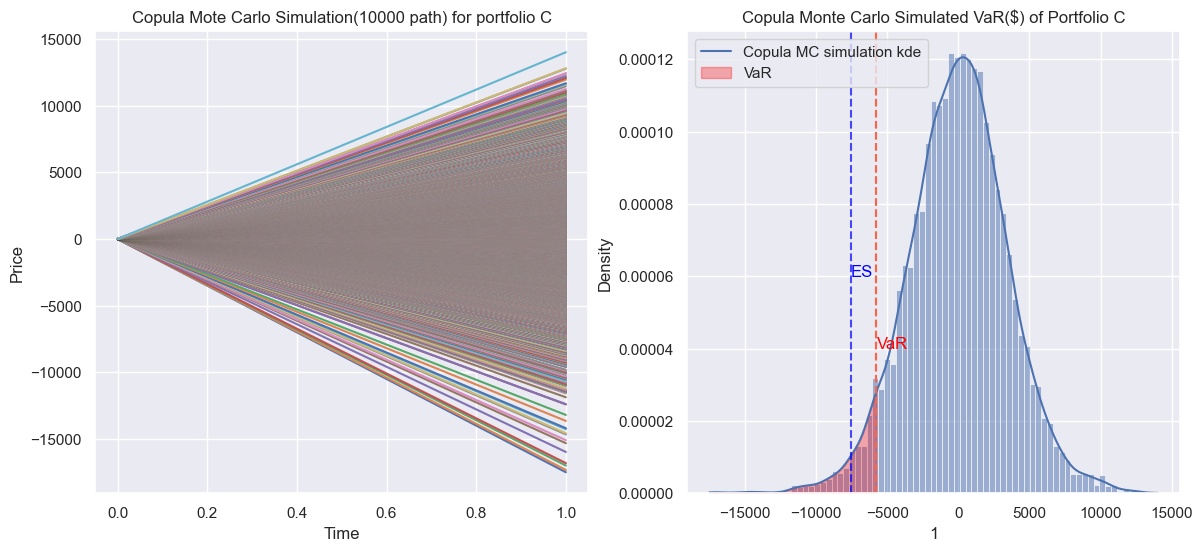

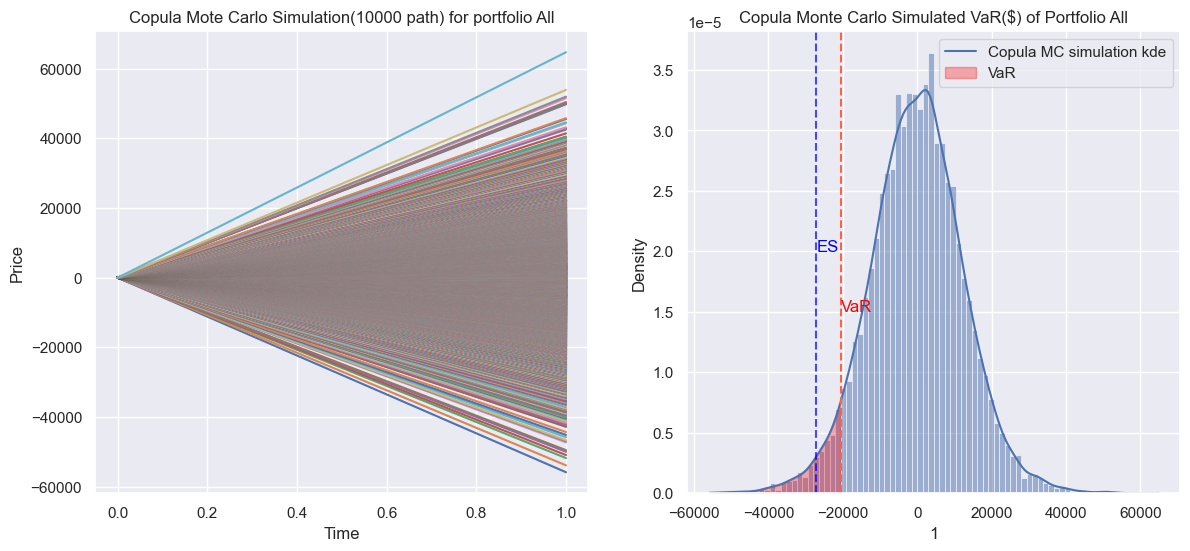

In [11]:
# Gaussian Copula Monte Carlo Simulation for Portfolio A
APortfolio=VaR_portfolio(portfolio.loc['A'],rt,price)
VaR_A=APortfolio.Copula_MC(T_mean0,plot=True,p_name='A')
ES_A=RiskMetrics.ES_historical(np.array(APortfolio.simulate_PV[1]))
plt.axvline(-ES_A,color="blue" ,alpha=0.7,linestyle='--') # plot the vertical line of ES_t
plt.text(-VaR_A,4e-5,s='VaR',color="red",alpha=1)
plt.text(-ES_A,6e-5,s='ES',color='blue',alpha=1)
print("VaR of portfolio A is {}".format(VaR_A))
print("ES of portfolio A is {}".format(ES_A))

# Gaussian Copula Monte Carlo Simulation for Portfolio B
BPortfolio=VaR_portfolio(portfolio.loc['B'],rt,price)
VaR_B=BPortfolio.Copula_MC(T_mean0,plot=True,p_name='B')
ES_B=RiskMetrics.ES_historical(np.array(BPortfolio.simulate_PV[1]))
plt.axvline(-ES_B,color="blue" ,alpha=0.7,linestyle='--') # plot the vertical line of ES_t
plt.text(-VaR_B,4e-5,s='VaR',color="red",alpha=1)
plt.text(-ES_B,6e-5,s='ES',color='blue',alpha=1)
print("VaR of portfolio B is {}".format(VaR_B))
print("ES of portfolio B is {}".format(ES_B))

# Gaussian Copula Monte Carlo Simulation for Portfolio C
CPortfolio=VaR_portfolio(portfolio.loc['C'],rt,price)
VaR_C=CPortfolio.Copula_MC(T_mean0,plot=True,p_name='C')
ES_C=RiskMetrics.ES_historical(np.array(CPortfolio.simulate_PV[1]))
plt.axvline(-ES_C,color="blue" ,alpha=0.7,linestyle='--') # plot the vertical line of ES_t
plt.text(-VaR_C,4e-5,s='VaR',color="red",alpha=1)
plt.text(-ES_C,6e-5,s='ES',color='blue',alpha=1)
print("VaR of portfolio C is {}".format(VaR_C))
print("ES of portfolio C is {}".format(ES_C))

# Gaussian Copula Monte Carlo Simulation for Portfolio All
AllPortfolio=VaR_portfolio(portfolio,rt,price)
VaR_All=AllPortfolio.Copula_MC(T_mean0,plot=True,p_name='All')
ES_All=RiskMetrics.ES_historical(np.array(AllPortfolio.simulate_PV[1]))
plt.axvline(-ES_All,color="blue" ,alpha=0.7,linestyle='--') # plot the vertical line of ES_t
plt.text(-VaR_All,1.5e-5,s='VaR',color="red",alpha=1)
plt.text(-ES_All,2e-5,s='ES',color='blue',alpha=1)
print("VaR of portfolio All is {}".format(VaR_All))
print("ES of portfolio All is {}".format(ES_All))

VaR of portfolio A is 8314.114055869253
ES of portfolio A is 10405.24245590327
VaR of portfolio B is 7078.514761769557
ES of portfolio B is 9035.43989985229
VaR of portfolio C is 5587.9050495346655
ES of portfolio C is 7471.3810547372705
VaR of portfolio All is 21275.01310993595
ES of portfolio All is 27147.6616482459


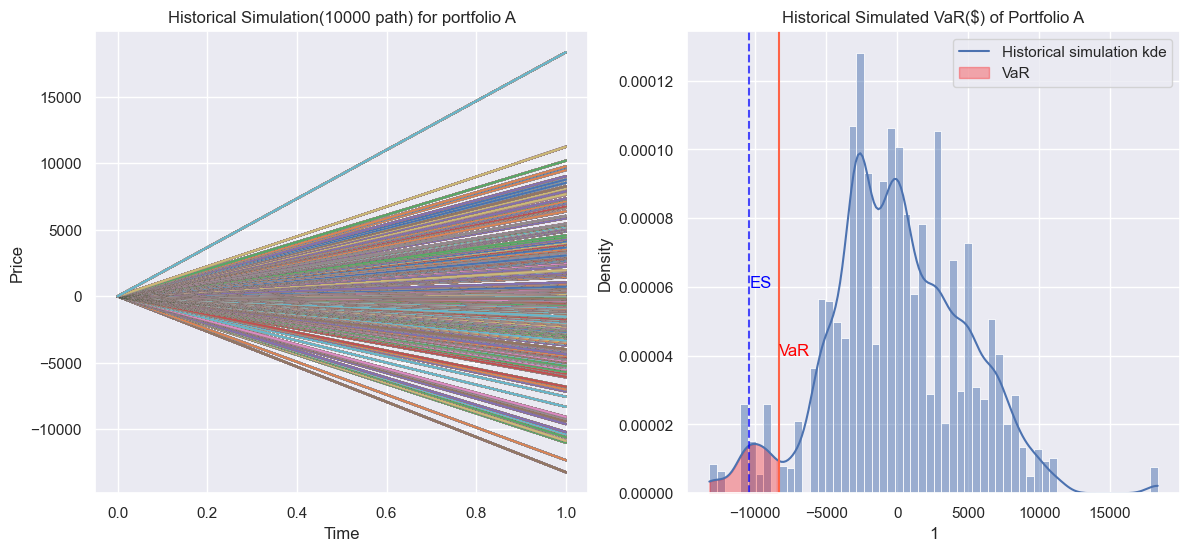

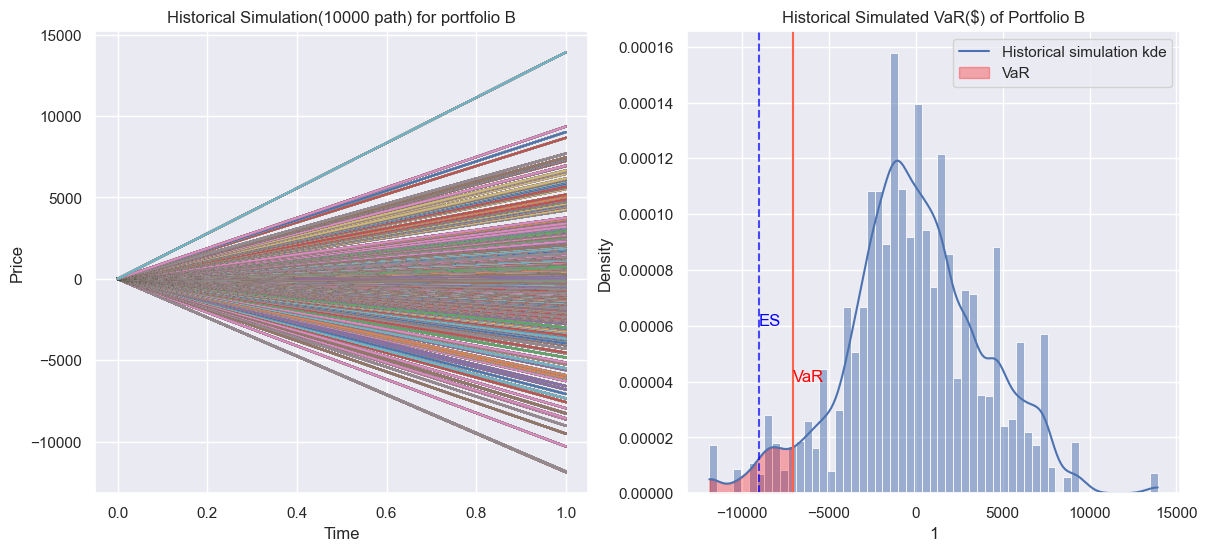

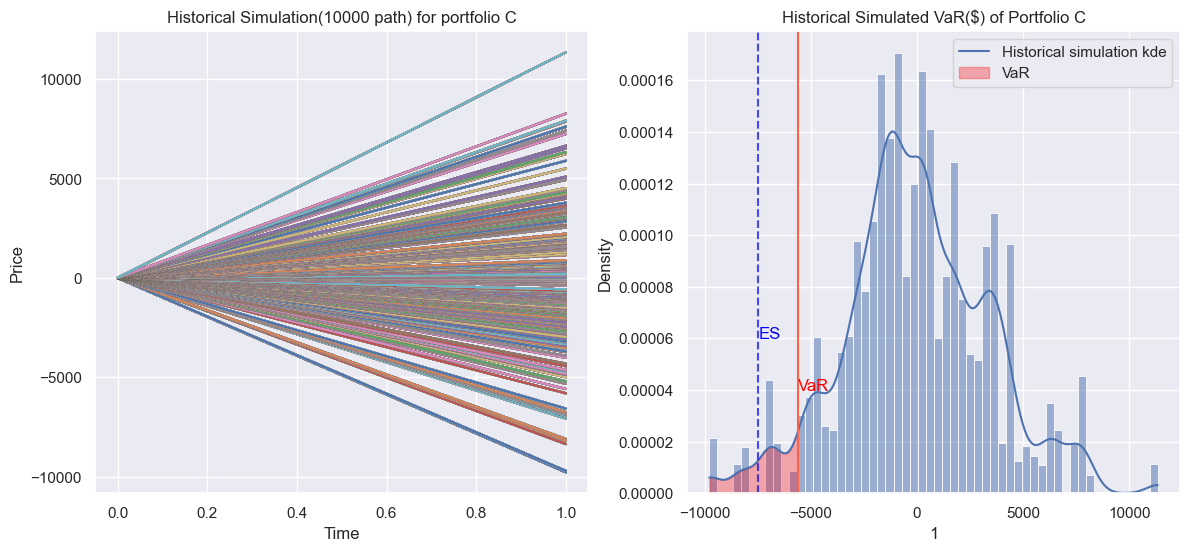

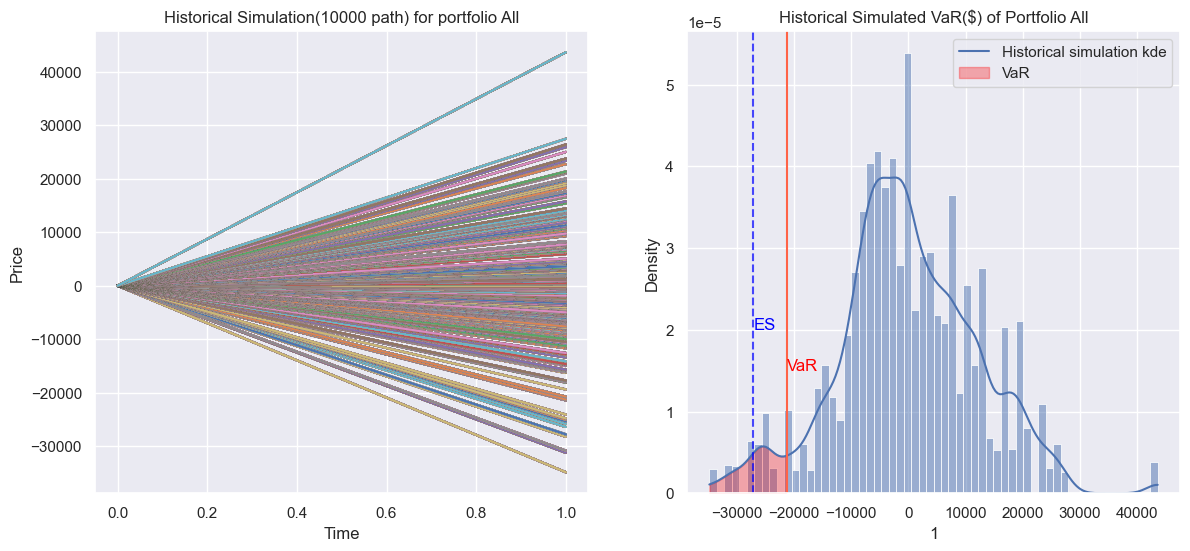

In [12]:
# Historical Simulation  for Portfolio A
APortfolio=VaR_portfolio(portfolio.loc['A'],rt,price)
VaR_A=APortfolio.historical_simulation(plot=True,p_name='A')
ES_A=RiskMetrics.ES_historical(np.array(APortfolio.simulate_PV[1]))
plt.axvline(-ES_A,color="blue" ,alpha=0.7,linestyle='--') # plot the vertical line of ES_t
plt.text(-VaR_A,4e-5,s='VaR',color="red",alpha=1)
plt.text(-ES_A,6e-5,s='ES',color='blue',alpha=1)
print("VaR of portfolio A is {}".format(VaR_A))
print("ES of portfolio A is {}".format(ES_A))

# Historical Simulation  for Portfolio B
BPortfolio=VaR_portfolio(portfolio.loc['B'],rt,price)
VaR_B=BPortfolio.historical_simulation(plot=True,p_name='B')
ES_B=RiskMetrics.ES_historical(np.array(BPortfolio.simulate_PV[1]))
plt.axvline(-ES_B,color="blue" ,alpha=0.7,linestyle='--') # plot the vertical line of ES_t
plt.text(-VaR_B,4e-5,s='VaR',color="red",alpha=1)
plt.text(-ES_B,6e-5,s='ES',color='blue',alpha=1)
print("VaR of portfolio B is {}".format(VaR_B))
print("ES of portfolio B is {}".format(ES_B))

# Historical Simulation  for Portfolio C
CPortfolio=VaR_portfolio(portfolio.loc['C'],rt,price)
VaR_C=CPortfolio.historical_simulation(plot=True,p_name='C')
ES_C=RiskMetrics.ES_historical(np.array(CPortfolio.simulate_PV[1]))
plt.axvline(-ES_C,color="blue" ,alpha=0.7,linestyle='--') # plot the vertical line of ES_t
plt.text(-VaR_C,4e-5,s='VaR',color="red",alpha=1)
plt.text(-ES_C,6e-5,s='ES',color='blue',alpha=1)
print("VaR of portfolio C is {}".format(VaR_C))
print("ES of portfolio C is {}".format(ES_C))

# Historical Simulation  for Portfolio All
AllPortfolio=VaR_portfolio(portfolio,rt,price)
VaR_All=AllPortfolio.historical_simulation(plot=True,p_name='All')
ES_All=RiskMetrics.ES_historical(np.array(AllPortfolio.simulate_PV[1]))
plt.axvline(-ES_All,color="blue" ,alpha=0.7,linestyle='--') # plot the vertical line of ES_t
plt.text(-VaR_All,1.5e-5,s='VaR',color="red",alpha=1)
plt.text(-ES_All,2e-5,s='ES',color='blue',alpha=1)
print("VaR of portfolio All is {}".format(VaR_All))
print("ES of portfolio All is {}".format(ES_All))

VaR of portfolio A is 5666.583287236458
ES of portfolio A is 7084.002586939622
VaR of portfolio B is 4504.712104261307
ES of portfolio B is 5662.550032132843
VaR of portfolio C is 3785.425364759008
ES of portfolio C is 4752.452947145515
VaR of portfolio All is 13571.227479146908
ES of portfolio All is 16934.989800314877


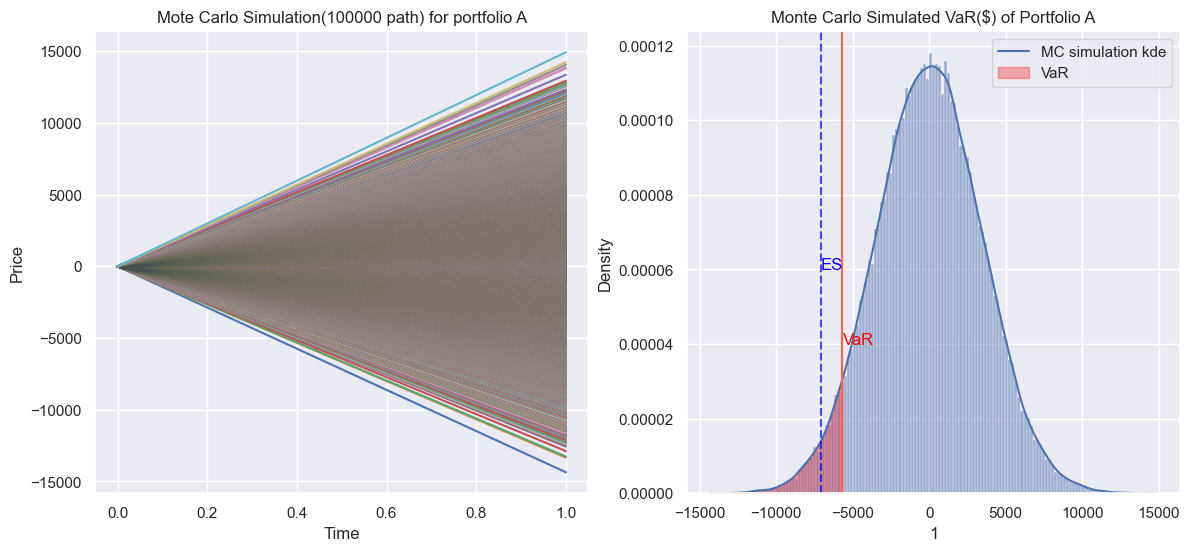

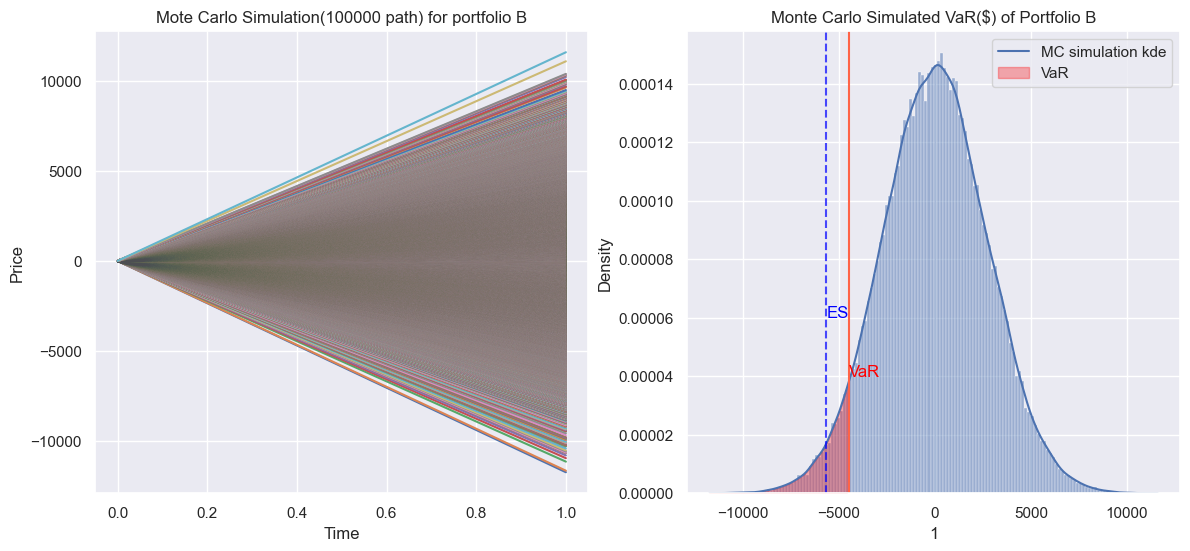

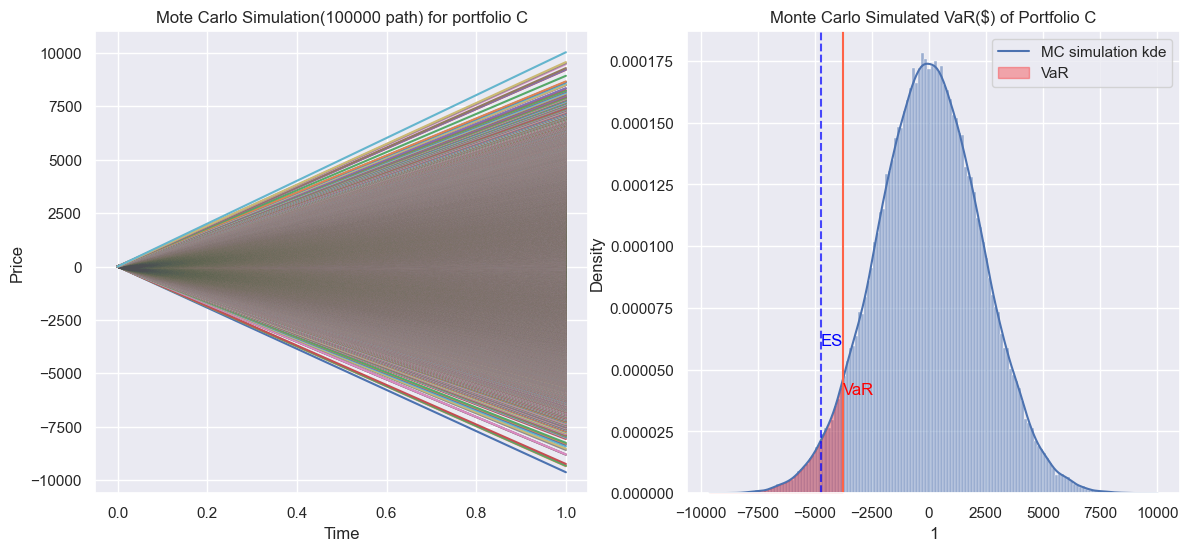

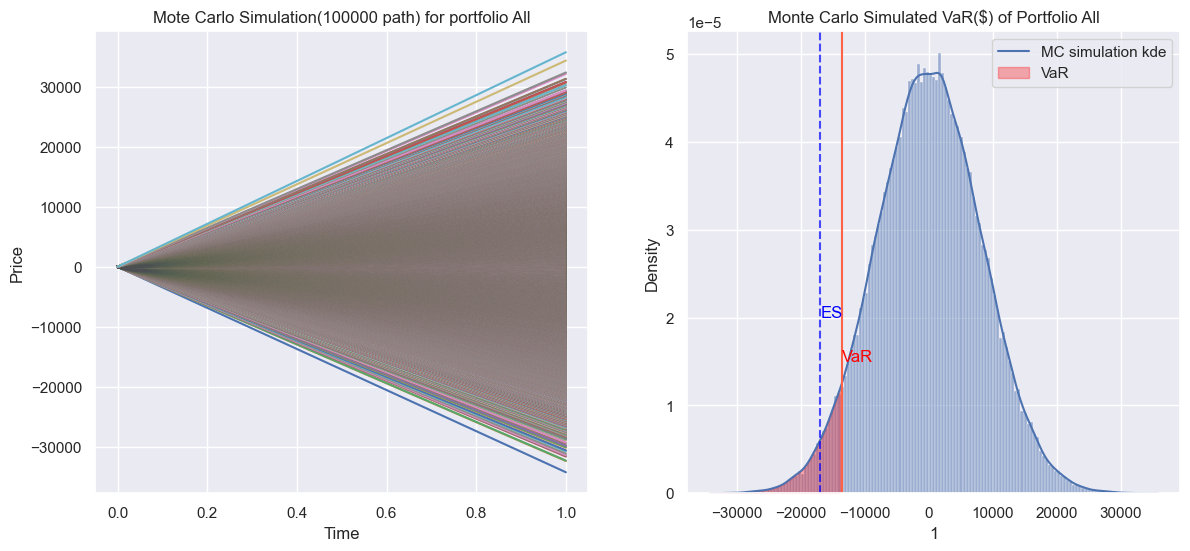

In [13]:
# Normal Simulation  for Portfolio A
APortfolio=VaR_portfolio(portfolio.loc['A'],rt,price)
VaR_A=APortfolio.normal_MC(plot=True,p_name='A')
ES_A=RiskMetrics.ES_historical(np.array(APortfolio.simulate_PV[1]))
plt.axvline(-ES_A,color="blue" ,alpha=0.7,linestyle='--') # plot the vertical line of ES_t
plt.text(-VaR_A,4e-5,s='VaR',color="red",alpha=1)
plt.text(-ES_A,6e-5,s='ES',color='blue',alpha=1)
print("VaR of portfolio A is {}".format(VaR_A))
print("ES of portfolio A is {}".format(ES_A))

# Normal Simulation  for Portfolio B
BPortfolio=VaR_portfolio(portfolio.loc['B'],rt,price)
VaR_B=BPortfolio.normal_MC(plot=True,p_name='B')
ES_B=RiskMetrics.ES_historical(np.array(BPortfolio.simulate_PV[1]))
plt.axvline(-ES_B,color="blue" ,alpha=0.7,linestyle='--') # plot the vertical line of ES_t
plt.text(-VaR_B,4e-5,s='VaR',color="red",alpha=1)
plt.text(-ES_B,6e-5,s='ES',color='blue',alpha=1)
print("VaR of portfolio B is {}".format(VaR_B))
print("ES of portfolio B is {}".format(ES_B))

# Normal Simulation  for Portfolio C
CPortfolio=VaR_portfolio(portfolio.loc['C'],rt,price)
VaR_C=CPortfolio.normal_MC(plot=True,p_name='C')
ES_C=RiskMetrics.ES_historical(np.array(CPortfolio.simulate_PV[1]))
plt.axvline(-ES_C,color="blue" ,alpha=0.7,linestyle='--') # plot the vertical line of ES_t
plt.text(-VaR_C,4e-5,s='VaR',color="red",alpha=1)
plt.text(-ES_C,6e-5,s='ES',color='blue',alpha=1)
print("VaR of portfolio C is {}".format(VaR_C))
print("ES of portfolio C is {}".format(ES_C))

# Normal Simulation  for Portfolio All
AllPortfolio=VaR_portfolio(portfolio,rt,price)
VaR_All=AllPortfolio.normal_MC(plot=True,p_name='All')
ES_All=RiskMetrics.ES_historical(np.array(AllPortfolio.simulate_PV[1]))
plt.axvline(-ES_All,color="blue" ,alpha=0.7,linestyle='--') # plot the vertical line of ES_t
plt.text(-VaR_All,1.5e-5,s='VaR',color="red",alpha=1)
plt.text(-ES_All,2e-5,s='ES',color='blue',alpha=1)
print("VaR of portfolio All is {}".format(VaR_All))
print("ES of portfolio All is {}".format(ES_All))